In [2]:
# Installing necessary libraries
#!pip install transformers datasets --quiet
#!pip install -U scikit-learn --quiet


In [1]:
from google.colab import files
uploaded = files.upload()  # Upload rct_data.zip


Saving rct_data.zip to rct_data.zip


In [2]:
import zipfile

with zipfile.ZipFile("rct_data.zip", 'r') as zip_ref:
    zip_ref.extractall("rct_data")

print("Extracted files in /rct_data")


Extracted files in /rct_data


**Data Processing**


In [27]:
import pandas as pd
df = pd.read_csv("rct_data/rct_data/rct_data.txt", sep="\t", names=["text", "label"], quoting=3)
df.dropna(inplace=True)
print("Total samples:", len(df))
df.head()


Total samples: 500105


,,,text,label
18439781,0,2011,Two patients subdued with a TASER® device: cas...,"In the United States, an increasing number of ..."
18468833,0,2011,A case of Takayasu arteritis causing subclavia...,The American Heart Association website defines...
18481181,0,2012,Pathophysiology of hypopituitarism in the sett...,The complex pathophysiology of traumatic brain...
18728056,1,2011,"The cardiovascular risk factor, soluble CD40 l...",[BACKGROUND] Soluble CD40 ligand (sCD40L) is a...
18790590,0,2011,Horner syndrome due to carotid dissection.,[BACKGROUND] Internal carotid artery dissectio...


In [30]:
# Filtering labels with at least 10 samples
label_counts = df['label'].value_counts()
valid_labels = label_counts[label_counts >= 10].index.tolist()
filtered_df = df[df['label'].isin(valid_labels)].copy()

#  10000 samples e
sample_size = min(10000, len(filtered_df))
df_sampled = filtered_df.sample(n=sample_size, random_state=42).reset_index(drop=True)

print("Sampled subset size:", len(df_sampled))
print("Unique labels in sample:", df_sampled['label'].nunique())
df_sampled['label'].value_counts()


✅ Sampled subset size: 195
✅ Unique labels in sample: 5


,count
label,
An amendment to this paper has been published and can be accessed via a link at the top of the paper.,103
A correction to this article has been published and is linked from the HTML and PDF versions of this paper. The error has been fixed in the paper.,29
An amendment to this paper has been published and can be accessed via the original article.,25
A correction to this article has been published and is linked from the HTML and PDF versions of this paper. The error has not been fixed in the paper.,23
This article has been withdrawn at the request of the author(s) and/or editor. The Publisher apologizes for any inconvenience this may cause. The full Elsevier Policy on Article Withdrawal can be found at http://www.elsevier.com/locate/withdrawalpolicy.,15


**Label Encoding & Splitting the Dataset**

In [40]:
# Encoding labels for the sampled data
label2id = {label: idx for idx, label in enumerate(df_sampled['label'].unique())}
id2label = {idx: label for label, idx in label2id.items()}

df_sampled['label'] = df_sampled['label'].map(label2id)

print("Label Mapping:", label2id)


Label Mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4}


In [41]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_sampled['text'].tolist(),
    df_sampled['label'].tolist(),
    test_size=0.2,
    random_state=42
)

print(f" Train size: {len(train_texts)}, Validation size: {len(val_texts)}")


✅ Train size: 156, Validation size: 39


**Fine-Tune BERT**

In [42]:
#!pip install transformers datasets --quiet

from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch


In [43]:
# Loading BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

# Converting to Huggingface Datasets
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/156 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

In [44]:
# Ensure keys/values are Python int, not NumPy int64
label2id = {str(label): int(idx) for idx, label in enumerate(df_sampled['label'].unique())}
id2label = {int(idx): str(label) for label, idx in label2id.items()}


In [45]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [47]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [48]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()


<ipython-input-48-feaca91ba644>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,1.140564
2,No log,0.991055
3,No log,0.941383


TrainOutput(global_step=60, training_loss=1.2856161753336588, metrics={'train_runtime': 85.2182, 'train_samples_per_second': 5.492, 'train_steps_per_second': 0.704, 'total_flos': 123139290673152.0, 'train_loss': 1.2856161753336588, 'epoch': 3.0})

**BERT Model Evaluation**

In [49]:
#model predictions
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(axis=1)


In [50]:
# Ensuring labels are numeric and get sorted unique class indices
unique_label_ids = sorted(set(val_labels + preds.tolist()))
target_names = [id2label[i] for i in unique_label_ids]

from sklearn.metrics import classification_report
print(classification_report(val_labels, preds, target_names=target_names))


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        27
           1       0.00      0.00      0.00         4
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         4
           4       1.00      1.00      1.00         1

    accuracy                           0.79        39
   macro avg       0.55      0.60      0.57        39
weighted avg       0.64      0.79      0.71        39



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


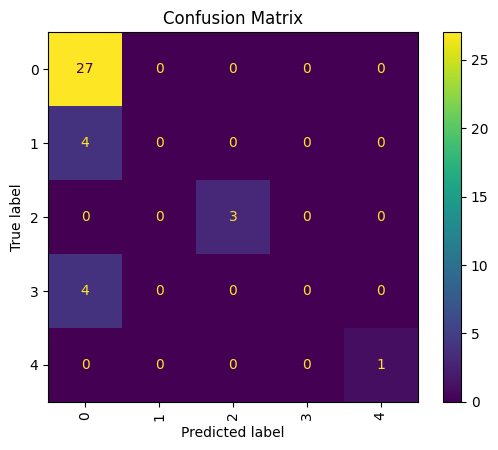

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(val_labels, preds, display_labels=target_names, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()


**Fine-tune DistilBERT**

In [52]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Loading tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/156 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

In [54]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_distilbert",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs_distilbert",
    logging_steps=10,
    load_best_model_at_end=True,
    save_strategy="epoch"
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [55]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()


<ipython-input-55-344491dfc41b>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.423200,1.025834
2,1.179700,0.864271
3,1.127100,0.790679


TrainOutput(global_step=60, training_loss=1.2587474187215169, metrics={'train_runtime': 43.4612, 'train_samples_per_second': 10.768, 'train_steps_per_second': 1.381, 'total_flos': 61998059335680.0, 'train_loss': 1.2587474187215169, 'epoch': 3.0})

In [56]:
# 1. predictions
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(axis=1)

# 2. Classification report
from sklearn.metrics import classification_report

target_names = [id2label[i] for i in sorted(set(val_labels))]
print(classification_report(val_labels, preds, target_names=target_names))


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        27
           1       0.00      0.00      0.00         4
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1

    accuracy                           0.77        39
   macro avg       0.35      0.40      0.37        39
weighted avg       0.60      0.77      0.67        39



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


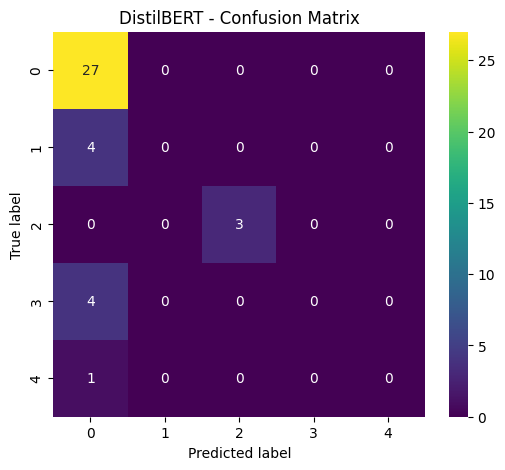

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("DistilBERT - Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


**RoBERTa Model**

In [58]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification

# Loading RoBERTa tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/156 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

In [60]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_roberta",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs_roberta",
    logging_steps=10,
    load_best_model_at_end=True,
    save_strategy="epoch"
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [61]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()


<ipython-input-61-344491dfc41b>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.428200,1.077935
2,1.259100,0.948721
3,1.141900,0.815511


TrainOutput(global_step=60, training_loss=1.2937125205993651, metrics={'train_runtime': 107.9197, 'train_samples_per_second': 4.337, 'train_steps_per_second': 0.556, 'total_flos': 123139290673152.0, 'train_loss': 1.2937125205993651, 'epoch': 3.0})

In [62]:
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(axis=1)


In [63]:
from sklearn.metrics import classification_report

target_names = [id2label[i] for i in sorted(set(val_labels))]
print(classification_report(val_labels, preds, target_names=target_names))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83        27
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         4
           4       1.00      1.00      1.00         1

    accuracy                           0.72        39
   macro avg       0.34      0.40      0.37        39
weighted avg       0.52      0.72      0.60        39



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


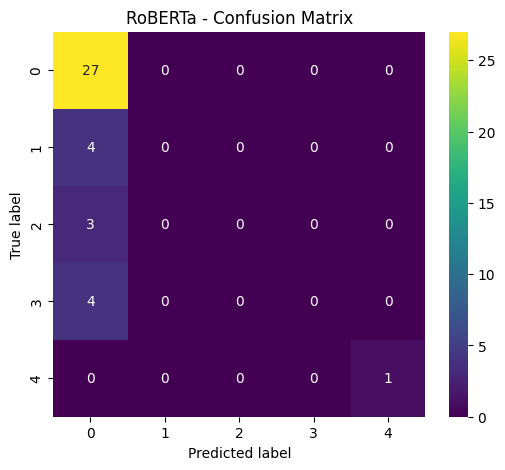

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("RoBERTa - Confusion Matrix")
plt.show()
